In [1]:
from GLMClass import GLMProbitClass
from MLEClass import MaximumLikelihoodMethod


import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from scipy.interpolate import CubicSpline
import math 
import os 

from scipy.stats import norm

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

In [2]:
df = pd.read_csv('data/MSACollapseCountData.csv')
hazardLevel = np.array(df['Intensity Measure'])
df = df.drop('Intensity Measure', 1)
colNames = df.columns
numGM = 45 * np.ones(len(hazardLevel))
returnPeriod = [15, 25, 50, 75, 100, 150, 250, 500, 1000, 2500, 2700, 3000, 3300, 3500, 3700, 4000]
rate = [1/i for i in returnPeriod]



In [3]:
temp2 = []
for i in colNames: 
    numCount = np.array(df['%s'%i])
    mleClass = MaximumLikelihoodMethod(hazardLevel, numCount, numGM, rate)
    temp2.append({'Building Name':i,
                 r'Median($\theta$)':mleClass.theta[0],
                 r'log-std($\beta$)':mleClass.theta[1],
                 r'Var[$\theta$]':mleClass.vcov_erf[0,0], #using error function 
                 r'Var[$\beta$]':mleClass.vcov_erf[1,1],
                 r'QVar[$\theta$]':mleClass.sandwich[0,0],
                 r'QVar[$\beta$]':mleClass.sandwich[1,1],
                 r'CoV_$\theta$': np.sqrt(mleClass.vcov_erf[0,0])/mleClass.theta[0],
                 r'CoV_$\beta$': np.sqrt(mleClass.vcov_erf[1,1])/mleClass.theta[1],
                 r'QCoV_$\theta$': np.sqrt(mleClass.sandwich[0,0])/mleClass.theta[0],
                 r'QCoV_$\beta$': np.sqrt(mleClass.sandwich[1,1])/mleClass.theta[1], 
                 r'MAFC($\lambda_c$)':mleClass.meanLambdaCollapse,
                 r'MLEStd[$\lambda_c$]':mleClass.MAFC(qmleTag = False),
                 r'QMLEStd[$\lambda_c$]':mleClass.MAFC(qmleTag = True),
                 '50yr_ProbCollapse':mleClass.getProbCollapse_years(numYear = 50),
                  'Var(lambdaCSimulated)':mleClass.varCollapseRate
        
    })
    
MLEresult = pd.DataFrame(temp2)
MLEresult.head(10)

,Building Name,Median($\theta$),log-std($\beta$),Var[$\theta$],Var[$\beta$],QVar[$\theta$],QVar[$\beta$],CoV_$\theta$,CoV_$\beta$,QCoV_$\theta$,QCoV_$\beta$,MAFC($\lambda_c$),MLEStd[$\lambda_c$],QMLEStd[$\lambda_c$],50yr_ProbCollapse,Var(lambdaCSimulated)
0,B1-Existing,1.219418,0.310060,0.001268,0.000645,0.000597,0.000363,0.029204,0.081906,0.020030,0.061453,0.002743,0.000281,0.000189,0.128156,5.747241e-08
1,B1-Retrofit,3.145158,0.303274,0.006406,0.000681,0.001126,0.000158,0.025447,0.086060,0.010669,0.041398,0.000150,0.000017,0.000007,0.007482,2.084493e-10
2,B2-Existing,2.381166,0.571759,0.008149,0.001566,0.004224,0.000794,0.037911,0.069203,0.027294,0.049295,0.000918,0.000166,0.000123,0.044841,2.586024e-08
3,B2-Retrofit,4.446205,0.399264,0.030248,0.002418,0.011564,0.001869,0.039116,0.123154,0.024187,0.108277,0.000081,0.000013,0.000009,0.004027,9.540849e-11
4,B3-Existing,0.812546,0.398092,0.000705,0.001059,0.000422,0.000298,0.032675,0.081760,0.025288,0.043391,0.007955,0.000715,0.000510,0.328157,3.673196e-07
5,B3-Retrofit,2.730449,0.517434,0.009539,0.001502,0.003934,0.000504,0.035771,0.074899,0.022971,0.043408,0.000506,0.000099,0.000068,0.024990,9.115555e-09
6,B4-Existing,1.406964,0.532839,0.002746,0.001108,0.000645,0.000345,0.037244,0.062459,0.018053,0.034870,0.003052,0.000384,0.000232,0.141535,1.262903e-07
7,B4-Retoifit,2.671139,0.490573,0.008490,0.001333,0.004038,0.000655,0.034495,0.074432,0.023790,0.052177,0.000483,0.000092,0.000077,0.023858,7.743527e-09


In [4]:
theta_all = MLEresult[r'Median($\theta$)']
beta_all = MLEresult[r'log-std($\beta$)']

var_theta_all = MLEresult[r'Var[$\theta$]']
var_beta_all = MLEresult[r'Var[$\beta$]']

In [5]:

var_theta_all_qmle = MLEresult[r'QVar[$\theta$]']
var_beta_all_qmle = MLEresult[r'QVar[$\beta$]']

Text(0.9, 0.92, '(b)')

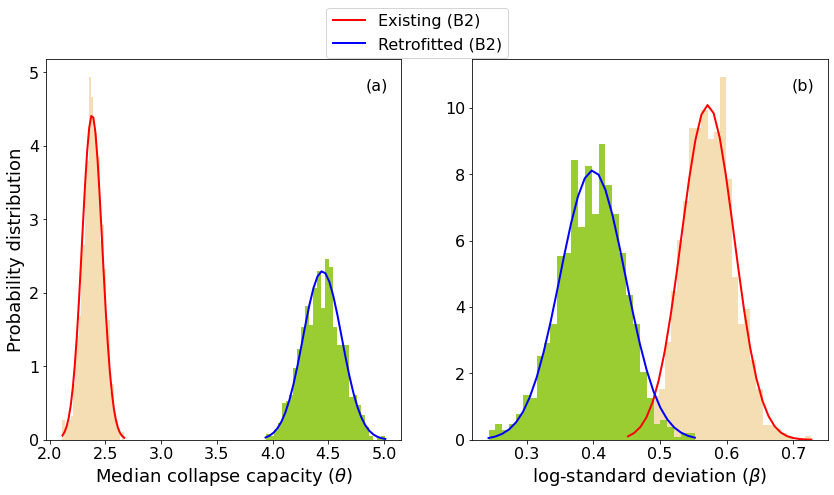

In [6]:
buildingNo = 3      #options are: 1, 3, 5, 7

theta = theta_all[buildingNo -1]
beta = beta_all[buildingNo -1]

Var_theta = var_theta_all[buildingNo -1]
Var_beta = var_beta_all[buildingNo -1]

##### retrofitted buildings
theta_retro = theta_all[buildingNo]
beta_retro = beta_all[buildingNo]

Var_theta_retro = var_theta_all[buildingNo]
Var_beta_retro = var_beta_all[buildingNo]


s_theta = np.random.normal(theta, np.sqrt(Var_theta), 1000)
s_beta = np.random.normal(beta, np.sqrt(Var_beta), 1000)

s_theta_r = np.random.normal(theta_retro, np.sqrt(Var_theta_retro), 1000)
s_beta_r = np.random.normal(beta_retro, np.sqrt(Var_beta_retro), 1000)


fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figheight(7)
fig.set_figwidth(14)
count, bins, ignored = ax1.hist(s_theta, 30, density=True, histtype = 'bar', facecolor = 'wheat')
ax1.plot(bins, 1/(np.sqrt(Var_theta) * np.sqrt(2 * np.pi)) * np.exp( - (bins - theta)**2 / (2 * Var_theta) ),
         linewidth=2, label = 'Existing (B%s)'%(int(buildingNo/2)+1), color='r')
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
count, bins, ignored = ax1.hist(s_theta_r, 30, density=True, histtype = 'bar', facecolor = 'yellowgreen')
ax1.plot(bins, 1/(np.sqrt(Var_theta_retro) * np.sqrt(2 * np.pi)) * np.exp( - (bins - theta_retro)**2 / (2 * Var_theta_retro) ),
         linewidth=2, color='b', label = 'Retrofitted (B%s)'% (int(buildingNo/2)+1))
# ax1.set_title(r'A PDF of median, $\theta$', fontdict={'fontsize': 18, 'fontweight': 'medium'})
ax1.set_xlabel(r'Median collapse capacity ($\theta$)',fontsize = 18 )
ax1.set_ylabel(r'Probability distribution',fontsize = 18 )
count, bins, ignored = ax2.hist(s_beta, 30, density=True, histtype = 'bar', facecolor = 'wheat')
ax2.plot(bins, 1/(np.sqrt(Var_beta) * np.sqrt(2 * np.pi)) * np.exp( - (bins - beta)**2 / (2 * Var_beta) ),
         linewidth=2, color='r')
count, bins, ignored = ax2.hist(s_beta_r, 30, density=True, histtype = 'bar', facecolor = 'yellowgreen')
ax2.plot(bins, 1/(np.sqrt(Var_beta_retro) * np.sqrt(2 * np.pi)) * np.exp( - (bins - beta_retro)**2 / (2 * Var_beta_retro) ),
         linewidth=2, color='b')
# ax2.plot(bins, norm.pdf())
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.set_xlabel(r'log-standard deviation ($\beta$)',fontsize = 18)
# ax2.set_title(r'A PDF of dispersion, $\beta$', fontdict={'fontsize': 18, 'fontweight': 'medium'})

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',fontsize = 16)
ax1.text(0.90, 0.92, '(a)',fontsize = 16, transform=ax1.transAxes)
ax2.text(0.90, 0.92, '(b)',fontsize = 16, transform=ax2.transAxes)
# fig.savefig('parameterDistribution_%s.png'%(int(buildingNo/2)+1))

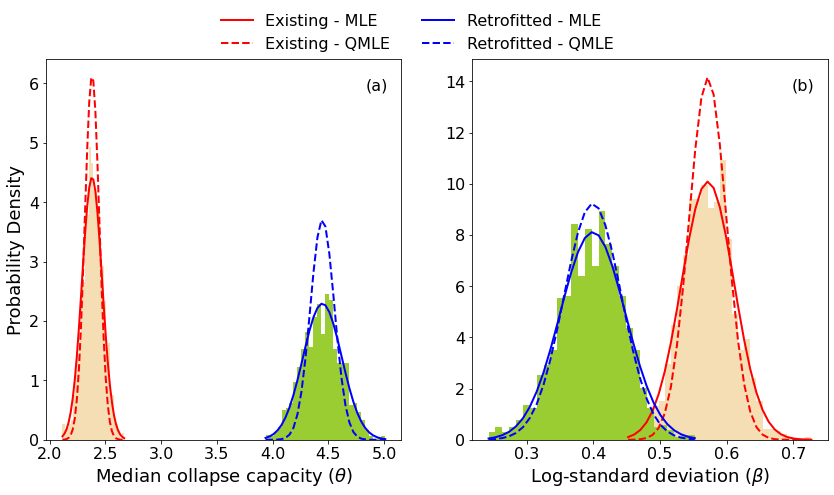

In [7]:
buildingNo = 3      #options are: 1, 3, 5, 7

theta = theta_all[buildingNo -1]
beta = beta_all[buildingNo -1]

Var_theta_qmle = var_theta_all_qmle[buildingNo -1]
Var_beta_qmle = var_beta_all_qmle[buildingNo -1]

##### retrofitted buildings
theta_retro = theta_all[buildingNo]
beta_retro = beta_all[buildingNo]

Var_theta_retro_qmle = var_theta_all_qmle[buildingNo]
Var_beta_retro_qmle = var_beta_all_qmle[buildingNo]


s_theta_qmle = np.random.normal(theta, np.sqrt(Var_theta_qmle), 1000)
s_beta_qmle = np.random.normal(beta, np.sqrt(Var_beta_qmle), 1000)

s_theta_r_qmle = np.random.normal(theta_retro, np.sqrt(Var_theta_retro_qmle), 1000)
s_beta_r_qmle = np.random.normal(beta_retro, np.sqrt(Var_beta_retro_qmle), 1000)


fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figheight(7)
fig.set_figwidth(14)
count, bins, ignored = ax1.hist(s_theta, 30, density=True, histtype = 'bar', facecolor = 'wheat')
ax1.plot(bins, 1/(np.sqrt(Var_theta) * np.sqrt(2 * np.pi)) * np.exp( - (bins - theta)**2 / (2 * Var_theta) ),
         linewidth=2, label = 'Existing - MLE', color='r')
ax1.plot(bins, 1/(np.sqrt(Var_theta_qmle) * np.sqrt(2 * np.pi)) * np.exp( - (bins - theta)**2 / (2 * Var_theta_qmle) ),
         linewidth=2, label = 'Existing - QMLE', linestyle = '--', color='r')
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
count, bins, ignored = ax1.hist(s_theta_r, 30, density=True, histtype = 'bar', facecolor = 'yellowgreen')
ax1.plot(bins, 1/(np.sqrt(Var_theta_retro) * np.sqrt(2 * np.pi)) * np.exp( - (bins - theta_retro)**2 / (2 * Var_theta_retro) ),
         linewidth=2, color='b', label = 'Retrofitted - MLE')
ax1.plot(bins, 1/(np.sqrt(Var_theta_retro_qmle) * np.sqrt(2 * np.pi)) * np.exp( - (bins - theta_retro)**2 / (2 * Var_theta_retro_qmle) ),
         linewidth=2, color='b',linestyle = '--', label = 'Retrofitted - QMLE')
# ax1.set_title(r'A PDF of median, $\theta$', fontdict={'fontsize': 18, 'fontweight': 'medium'})
ax1.set_xlabel(r'Median collapse capacity ($\theta$)',fontsize = 18 )
ax1.set_ylabel(r'Probability Density',fontsize = 18 )
count, bins, ignored = ax2.hist(s_beta, 30, density=True, histtype = 'bar', facecolor = 'wheat')
ax2.plot(bins, 1/(np.sqrt(Var_beta) * np.sqrt(2 * np.pi)) * np.exp( - (bins - beta)**2 / (2 * Var_beta) ),
         linewidth=2, color='r')
ax2.plot(bins, 1/(np.sqrt(Var_beta_qmle) * np.sqrt(2 * np.pi)) * np.exp( - (bins - beta)**2 / (2 * Var_beta_qmle) ),
         linewidth=2,linestyle = '--', color='r')
count, bins, ignored = ax2.hist(s_beta_r, 30, density=True, histtype = 'bar', facecolor = 'yellowgreen')
ax2.plot(bins, 1/(np.sqrt(Var_beta_retro) * np.sqrt(2 * np.pi)) * np.exp( - (bins - beta_retro)**2 / (2 * Var_beta_retro) ),
         linewidth=2, color='b')
ax2.plot(bins, 1/(np.sqrt(Var_beta_retro_qmle) * np.sqrt(2 * np.pi)) * np.exp( - (bins - beta_retro)**2 / (2 * Var_beta_retro_qmle) ),
         linewidth=2,linestyle = '--', color='b')
# ax2.plot(bins, norm.pdf())
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.set_xlabel(r'Log-standard deviation ($\beta$)',fontsize = 18)
# ax2.set_title(r'A PDF of dispersion, $\beta$', fontdict={'fontsize': 18, 'fontweight': 'medium'})

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',fontsize = 16, ncol = 2, frameon = False)
ax1.text(0.90, 0.92, '(a)',fontsize = 16, transform=ax1.transAxes)
ax2.text(0.90, 0.92, '(b)',fontsize = 16, transform=ax2.transAxes)
fig.savefig('parameterDistributionCompiled_%s.png'%(int(buildingNo/2)+1))

## Taking a close look at an individual building: B2 Existing

In [8]:
numCount1 = np.array(df['B2-Existing'])
trial = MaximumLikelihoodMethod(hazardLevel, numCount1, numGM, rate)
trial.theta #estimated parameters

array([2.38116588, 0.57175945])

In [9]:
trial.A

array([[-122.75729289,    5.50523365],
       [   5.50523365, -638.98305708]])

Score computed using error function. Please refer to the paper for the details on the usage of error function.

In [10]:
trial.score_erf

array([[ 63.60399301, -14.19520186],
       [-14.19520186, 324.09241377]])

Variance-covariance matrix computed using Inverse of Fisher's Information matrix

In [11]:
trial.vcov_erf

array([[8.14930426e-03, 7.02112889e-05],
       [7.02112889e-05, 1.56559164e-03]])

Variance0-covariance matrix computes using Sandwich estimator

In [12]:
trial.sandwich

array([[ 4.22401495e-03, -6.99770232e-08],
       [-6.99770232e-08,  7.94375516e-04]])

In [13]:
#fitted parameters from Generalized Linear Model with probit link function
params = trial.GLMmodel.fit.params
#variance-covariance of the fitted params
vcov = trial.GLMmodel.vcov


Transforming the parameters from GLM to median and log-std deviation

In [14]:
theta = np.exp(-params[0]/params[1])
beta = 1/params[1]
print(theta)
print(beta)

2.3811433806485196
0.5717505631272447


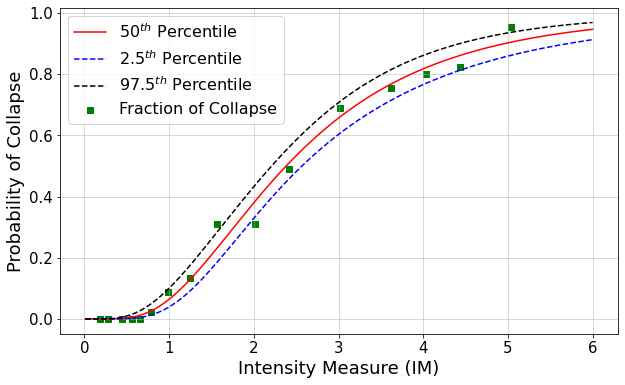

In [15]:
x = np.linspace(0.01,6,205)

meanEta = params[0] + params[1] * np.log(x)
varEta = vcov['Intercept'][0] + vcov['logIM'][1] * np.log(x)**2 + 2 * vcov['Intercept'][1] * np.log(x)

stdEta = np.sqrt(varEta)

muPc = norm.cdf(meanEta)
muPc_upper = norm.cdf(norm.ppf(0.975)*np.sqrt(varEta) + meanEta)
muPc_lower = norm.cdf(norm.ppf(0.025)*np.sqrt(varEta) + meanEta)

plt.figure(figsize = (10,6))
plt.plot(x, muPc, color = 'red' , label = r'$50^{th}$ Percentile' )
plt.plot(x, muPc_lower, color = 'blue',linestyle='dashed', label = r'$2.5^{th}$ Percentile' )
plt.plot(x, muPc_upper, color = 'black',linestyle='dashed', label = r'$97.5^{th}$ Percentile' )
plt.scatter(hazardLevel, numCount1/numGM, color = 'green', marker = 's', label = 'Fraction of Collapse')

plt.xlabel('Intensity Measure (IM)', fontsize = 18)
plt.ylabel('Probability of Collapse', fontsize = 18)
plt.legend(fontsize = 16)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(linewidth = 0.5)
# plt.savefig('ConfidenceInterval.png')

In [16]:
varcov = trial.vcov_erf
